In [162]:
import json
import jieba
import pandas
import numpy as np
import torch
import tqdm
import matplotlib.pyplot as plt
import random

myseed = 12345
torch.manual_seed(myseed)
torch.random.manual_seed(myseed)
random.seed(0)
np.random.seed(myseed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(myseed)
torch.autograd.set_detect_anomaly(True)  # 可在NaN 出现时报错，定位错误代码。正向传播时：开启自动求导的异常侦测
# 反向传播时：在求导时开启侦测
#with torch.autograd.detect_anomaly():
#    loss.backward()
torch.multiprocessing.set_sharing_strategy('file_system')

In [163]:
# 加载数据集
with open("./dataset/HPD/cn_train_set.json", 'r') as file:
    train_file = json.load(file)
with open("./dataset/HPD/cn_test_set.json", 'r') as file:
    test_file = json.load(file)

In [164]:
# 加载停用词表
with open('dataset/停用词表.txt', encoding='utf-8') as f:
    con = f.readlines()
    stop_words = set()
    for i in con:
        i = i.replace("\n", "")
        stop_words.add(i)

In [165]:
# 对对话词元化
i = 0
train_words = []
for segment in train_file:
    for line in train_file[segment]["对话历史"]:
        line_words = []
        line = line.split("：")[1]
        print(line)
        tokens = jieba.cut(line, cut_all=False)
        for token in tokens:
            # 去停用词
            if token not in stop_words:
                line_words.append(token)
        train_words.append(line_words)

i = 0
test_words = []
for segment in test_file:
    for line in test_file[segment]["对话历史"]:
        line_words = []
        line = line.split("：")[1]
        tokens = jieba.cut(line, cut_all=False)
        for token in tokens:
            # 去停用词
            if token not in stop_words:
                line_words.append(token)
        test_words.append(line_words)

……疯子一样，一路吼个没完，这些小兔崽子。
我梦见过一辆摩托车，那车还飞呢。
摩托车不会飞!
我知道摩托车不会飞，那只是一个梦。
石墙中学开学的第一天，他们就会把新生的头浸到马桶里。要不要上楼去试一试?
不用了，多谢。可怜的马桶从来没有泡过像你的头这样叫人倒胃口的脑袋——它可能会吐呢。
去拿信，达力。
叫哈利去捡。哈利去捡。
达力去捡
用你的斯梅廷手杖赶他去捡。
玛姬病倒了，吃了有问题的油螺……
老爸!老爸，哈利收到什么东西了!
那是写给我的!
谁会给你写信?佩——佩——佩妮!
德思礼!哎呀!我的天——德思礼!
我要看那封信。
我要看。因为那封信是写给我的。
你们俩，统统给我出去。
我要我的信!
我的信呢?是谁写给我的?
没有人。因为写错了地址才寄给你的。我已经把信烧掉了。
根本没有写错，上边还写着我住在碗柜里呢。
住嘴唔——不错，哈利——说起这个碗柜，你姨妈和我都考虑到……你已经长大了，这地方确实小了点……我们想，你不如搬到达力的另外一间卧室比较好。
为什么?
这是一个梦，我梦见一个叫海格的巨人，他来对我说，要我进一所魔法学校。等我一睁眼，我准在家里，在碗柜里。又是佩妮姨妈在捶门了。好了，我这就起来。
别抓。
海格!这里有一只猫头鹰——
把钱付给它。
什么?
它要你付送报费。你在外衣袋里找找。给它五个纳特。
‘纳特’?
那些小铜板。咱们最好还是早点走吧．哈利，今天还有好多事要做呢，要去伦敦给你买上学需要的所有东西。
唔，海格?
怎么?
我一个钱也没有，昨天晚上你已经听弗农姨父说过了，他不会花钱让我去学魔法的。
这个你不用担心，你以为你父母什么也没有给你留下吗?
可要是连他们的房子全都毁了——
他们是不会把黄金放在家里的，孩子!我们第一站去古灵阁。巫师银行。来一根香肠吧，冷的吃着味道也可以——加上一块你的生日蛋糕更不错。
巫师还有银行?
只有一家。古灵阁。是妖精们开的。
妖精
东西都带好了吗?那就走吧。
您是怎么到这里来的?
飞过来的。
飞?
是的——不过我们得坐这条船回去。找到你以后，我就不能用法术了。划船好像有点丢人，不过，我要是让——让——船开快一点，  你能在霍格沃茨不提这件事吗?
当然可以。您为什么说疯子才会去抢古灵阁呢?
因为他们会咒语——会施妖术。他们说那些防范最严密的金库都由龙把守。要到那里还得先找到路——古灵阁在伦敦地下好几百英里的地方呢，明白吗?

In [166]:
# 构建词表
class Vocab:
    def __init__(self, words, min_freq = 0) -> None:
        if tokens is None:
            return

        # 计算频率
        self.words_num = {}
        for line in words:
            for word in line:
                if word not in self.words_num:
                    self.words_num[word] = 1
                else:
                    self.words_num[word] += 1

        # 删掉出现次数较少的词
        self.words = words
        for word in list(self.words_num.keys()):
            if self.words_num[word] <= min_freq:
                del self.words_num[word]
        for i in range(len(self.words)):
            for j in range(len(self.words[i])):
                if self.words[i][j] not in self.words_num:
                    self.words[i][j] = "<unk>"
        self.words_num["<unk>"] = 0
        self.len = len(self.words_num)

        # 按照出现次数排序
        self.words_num = sorted(self.words_num.items(),  key=lambda d: d[1], reverse=True)

        # index 与 word
        i = 0
        self.idx_word = {}
        for key in self.words_num:
            self.idx_word[key[0]] = i
            i += 1
    
    def __word__(self, index):
        return self.words_num[index]

    def __words__(self):
        return self.words
    
    def __words_num__(self):
        return self.words_num
    
    def __index__(self, str):
        return self.idx_word[str]
    
    def __len__(self):
        return self.len

train_table = Vocab(train_words, 5)
test_table= Vocab(test_words, 5)

In [167]:
# 划分数据集
def seq_data_iter_random(vtab, corpus, batch_size, num_steps):
    batch_x = []
    batch_y = []
    for i in range(len(corpus)):
        x = []
        y = []
        for j in range(batch_size):
            start_index = np.random.randint(num_steps)
            # x
            if i % 2:
                cur_x = []
                if len(corpus[i]) < (start_index + num_steps):
                    for k in range(start_index, len(corpus[i])):
                        cur_x.append(vtab.__index__(corpus[i][k]))
                    n = 0
                    while(n < num_steps - len(cur_x)):
                        cur_x.append(0)
                else:
                    for k in range(start_index, start_index + num_steps):
                        cur_x.append(vtab.__index__(corpus[i][k]))
               
                x.append(cur_x)
            # y
            else:
                cur_y = []
                if len(corpus[i]) < (start_index + num_steps):
                    for k in range(start_index, len(corpus[i])):
                        cur_y.append(vtab.__index__(corpus[i][k]))
                    n = 0
                    while(n < num_steps - len(cur_y)):
                        cur_y.append(0)
                else:
                    for k in range(start_index, start_index + num_steps):
                        cur_y.append(vtab.__index__(corpus[i][k]))
                y.append(cur_y)
        if i % 2:
            batch_x.append(x)
        else:
            batch_y.append(y)
    return batch_x, batch_y

train_batch_x, train_batch_y = seq_data_iter_random(train_table, train_table.__words__(), 2, 5)
test_batch_x, test_batch_y = seq_data_iter_random(test_table, test_table.__words__(), 2, 5)

In [168]:
# 使用 GPU
def try_gpu(i=0):  #@save
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def try_all_gpus():  #@save
    """返回所有可用的GPU，如果没有GPU，则返回[cpu(),]"""
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

In [169]:
# 转为张量
train_x = torch.tensor(data=train_batch_x, device=try_gpu(), requires_grad=True, dtype=torch.float)
#train_x = torch.nn.functional.one_hot(train_x.to(torch.int64), num_classes=train_table.__len__())
train_y = torch.tensor(data=train_batch_y, device=try_gpu(), dtype=torch.float)
test_x = torch.tensor(data=test_batch_x, device=try_gpu(), requires_grad=True, dtype=torch.float)
test_y = torch.tensor(data=test_batch_y, device=try_gpu(), dtype=torch.float)

In [170]:
# 1
'''
class GRU(torch.nn.Module):
    def __init__(self, word_num, *args, **kwargs):
        super(GRU, self).__init__()
        self.state = torch.ones(word_num)
        self.Z_w = torch.ones(word_num)
        self.H_zw =  torch.ones(word_num)
        self.bz = torch.tensor(1, requires_grad=True)
        self.R_w = torch.ones(word_num)
        self.R_rw = torch.ones(word_num)
        self.br = torch.tensor(1, requires_grad=True)
        self.W_xh = torch.ones(word_num)
        self.W_hh = torch.ones(word_num)
        self.b_h = torch.tensor(1, requires_grad=True)
        self.b_o = torch.ones(word_num)
        self.W_hq = torch.tensor(1, requires_grad=True)

    def forward(self, x_list):
        for t in range(len(x_list)):
            if t > 0:
                Z_t = torch.sigmoid(self.Z_w @ x_list[t] + self.state[t - 1] @ self.H_zw + self.bz) 
                R_t = torch.sigmoid(self.r_w @ x_list[t] + self.state[t - 1] @ self.R_rw + self.br)
                H_temp = torch.tanh(x_list[t] @ self.W_xh + (torch.dot(R_t, self.state[t - 1])) @ self.W_hh + self.b_h)
                H_t = torch.dot(Z_t, self.state[t-1]) + torch.dot(1 - Z_t, H_temp)
                Y = H_t @ self.W_hq + self.b_o
'''

'\nclass GRU(torch.nn.Module):\n    def __init__(self, word_num, *args, **kwargs):\n        super(GRU, self).__init__()\n        self.state = torch.ones(word_num)\n        self.Z_w = torch.ones(word_num)\n        self.H_zw =  torch.ones(word_num)\n        self.bz = torch.tensor(1, requires_grad=True)\n        self.R_w = torch.ones(word_num)\n        self.R_rw = torch.ones(word_num)\n        self.br = torch.tensor(1, requires_grad=True)\n        self.W_xh = torch.ones(word_num)\n        self.W_hh = torch.ones(word_num)\n        self.b_h = torch.tensor(1, requires_grad=True)\n        self.b_o = torch.ones(word_num)\n        self.W_hq = torch.tensor(1, requires_grad=True)\n\n    def forward(self, x_list):\n        for t in range(len(x_list)):\n            if t > 0:\n                Z_t = torch.sigmoid(self.Z_w @ x_list[t] + self.state[t - 1] @ self.H_zw + self.bz) \n                R_t = torch.sigmoid(self.r_w @ x_list[t] + self.state[t - 1] @ self.R_rw + self.br)\n                H_temp 

In [171]:
# 2

class GRU(torch.nn.Module):
    def __init__(self, words_num, input_size, hidden_size, output_size):
        super(GRU, self).__init__()
        self.gru = torch.nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, words_num * output_size), torch.nn.Tanh()
        )
        self.words_num = words_num

    def forward(self, x):
        # x 的形状: (batch_size, seq_len, input_size)
        out, hidden = self.gru(x)
        # 取最后一个时间步的输出
        out = out[:, -1, :]
        out = self.fc(out)
        out = out.reshape(x.shape[0], 2, 5, self.words_num)
        out = torch.argmax(out, dim=3)
        output = torch.tensor(out, requires_grad=True, dtype=torch.float)
        return output

In [172]:
print(train_table.__len__())
model = GRU(train_table.__len__(), 5, 256, 10)
model = model.to(device=try_gpu())

# 定义优化器和损失函数
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.MSELoss()

epochs= 1000

Loss_data = {
    "train": [],
    "dev": []
}

train_len = len(train_x)
test_len = len(test_x)

# 训练
for i in tqdm.tqdm(range(epochs)):
    Loss = 0
    model.train()
    running_train_loss = 0.0
    y_hat = model(train_x)
    #state = state_new
    loss = criterion(y_hat, train_y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    running_train_loss += loss.item()
    Loss_data["train"].append(loss.item())

    # 训练损失
    epoch_train_loss = running_train_loss / train_len
    perplexity_train = np.exp(running_train_loss / train_len)


    model.eval()
    # 测试损失
    running_test_loss = 0.0
    with torch.no_grad():
        outputs = model(test_x)
        outputs = outputs.to(torch.float)
        outputs = outputs.requires_grad_(True)
        pred = outputs.reshape(test_x.shape[0], 2, 5)
        loss = criterion(pred, test_y)
        running_test_loss += loss.item()
        Loss_data["dev"].append(loss.item())
    epoch_test_loss = running_test_loss / test_len
    Loss_data["dev"].append(epoch_test_loss)
    perplexity_test = np.exp(running_test_loss / test_len)

1923


  0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_9529/1951183719.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = torch.tensor(out, requires_grad=True, dtype=torch.float)
/tmp/ipykernel_9529/239338209.py:51: RuntimeWarning: overflow encountered in exp
  perplexity_test = np.exp(running_test_loss / test_len)
100%|██████████| 1000/1000 [00:56<00:00, 17.64it/s]


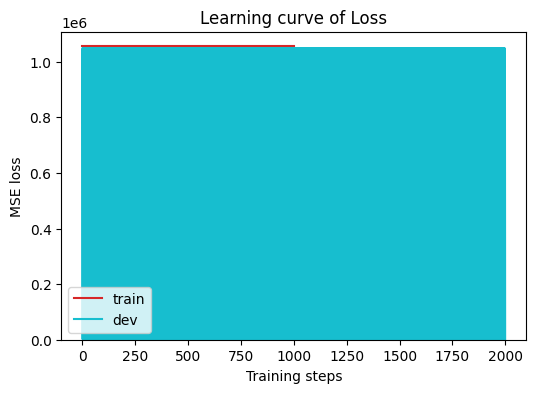

In [175]:
def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    x_1 = len(loss_record['train'])
    x_2 = len(loss_record["dev"])
    plt.figure(figsize=(6, 4))
    plt.plot(range(x_1), loss_record['train'], c='tab:red', label='train')
    plt.plot(range(x_2), loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, )
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

plot_learning_curve(Loss_data, "Loss")

In [176]:
print("perplexity train: ", perplexity_train)
print("perplexity test: ", perplexity_test)

perplexity train:  6.357491084834932e+89
perplexity test:  inf
